##**Imports**

In [ ]:
# import fastbook
# fastbook.setup_book()

# from fastbook import *

In [ ]:
from fastai.text.all import *

## **NLP Deep Dive: RNNs**

### **What is a language model?**

A `language model` is a model that has been trained to guess what the next word in a text is (having read the ones before).

This kind of task is called `self-supervised learning`: we do not need to give labels to our model, just feed it lots and lots of texts.

**Self-supervised learning:**  Training a model using labels that are embedded in the `independent variable`, rather than requiring external labels. 

For instance, training a model to predict the next word in a text

### **IMDB Movie Reviews**

**Say you want to build a language model to classify IMDb reviews:**  

- You can use a language model pretrained on Wikipedia, and great results by directly fine-tuning this language model to a movie review classifier. **But with one extra step, we can do even better**

- The `Wikipedia` English is slightly different from the `IMDb` English, so instead of jumping directly to the classifier, **we could fine-tune our pretrained language model to the IMDb corpus and then use that as the base for our classifier**.

**NOTE:**

- **Even if our language model knows the basics of the language we are using in the task (e.g., our pretrained model is in English), it helps to get used to the style of the corpus we are targeting**. 

- **It may be more informal language, or more technical, with new words to learn or different ways of composing sentences.**

- **In the case of the IMDb dataset, there will be lots of names of movie directors and actors, and often a less formal style of language than that seen in Wikipedia.**

#### **Why do this?**


**Practically, you get better results if you fine-tune the (sequence-based) language model prior to fine-tuning the classification model.**

- For instance, for the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached.

- There are 25,000 labeled reviews in the training set and 25,000 in the validation set, that makes 100,000 movie reviews altogether. 

- We can use all of these reviews to `fine-tune` the pretrained language model, which was trained only on `Wikipedia` articles; this will result in a language model that is particularly good at predicting the next word of a movie review.

**This is known as the `Universal Language Model Fine-tuning` (ULMFit) approach.**

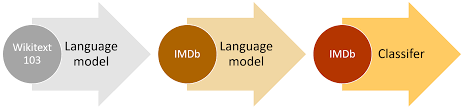

## **Steps necessary to create a language model**

- **Tokenization::** Convert the text into a list of words.

- **Numericalization::** Make a list of all of the unique words that appear `(the vocab)`, and convert each word into a number, by looking up its index in the vocab.

- **Language model data loader creation::** fastai provides an `LMDataLoader` class which automatically handles creating a dependent variable that is offset from the independent variable by one token. 
  - It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required.

- **Language model creation::** we will be using a recurrent neural network `(RNN)` - for now, you can think of it as just another deep neural network.

## **Text Preprocessing**

### **Tokenization**

**There are three main approaches to tokenization:**

- **Word-based::** Split a sentence on spaces, as well as applying language-specific rules to try to separate parts of meaning even when there are no spaces (such as turning `"don't"` into `"do n't"`). 

  - Generally, punctuation marks are also split into separate tokens.

- **Subword based::** Split words into smaller parts, based on the most commonly occurring substrings. 

  - For instance, **"occasion"** might be tokenized as `"o c ca sion."`

- **Character-based::** Split a sentence into its individual characters.


### **Word Tokenization with fastai**

**Fastai provides a consistent interface to a range of tokenizers in external libraries.**
- The default English word tokenizer for fastai uses a library called `spaCy`

#### **Let's try it out with the `IMDb` dataset**

In [ ]:
from fastai.text.all import *

In [ ]:
path = untar_data(URLs.IMDB)

**We'll need to grab the text files in order to try out a tokenizer**. 

- Just like `get_image_files`, which gets all the **image files** in a path, `get_text_files` gets all the **text** files in a path. 

- We can also optionally pass `folders` to restrict the search to a particular list of subfolders:



In [ ]:
files = get_text_files(path, folders = ['train', 'test', 'unsup'])

**Here's a review that we'll tokenize (we'll just print the start of it here to save space):**

In [ ]:
txt = files[0].open().read()

txt[:75]

'When "Woodstock" occurred, I was a 15 y.o French teenager. Watching the fil'

**NOTE:**

- Rather than directly using `SpacyTokenizer`, however, we'll use `WordTokenizer`.

- This will always point to fastai's current default word tokenizer (which may not necessarily be `spaCy`).

**We'll use fastai's `coll_repr(collection, n)` function to display the results.**

- This displays the first `n` items of `collection`, along with the full size


**Note:** Fastai's tokenizers take a `collection` of documents to tokenize, so we have to wrap `txt` in a list.

In [ ]:
spacy = WordTokenizer()

toks = first(spacy([txt]))

print(coll_repr(toks, 30))

(#421) ['When','"','Woodstock','"','occurred',',','I','was','a','15','y.o','French','teenager','.','Watching','the','film','again',',','yesterday',',','I',"'ve",'been','stunned','by','its','quality',',','its'...]


**NOTE:**

-  SpaCY has a sophisticated rules engine with special rules for URLs, individual special English words, and much more. 

In [ ]:
first(spacy(['The U.S. dollar 1.00.']))

(#5) ['The','U.S.','dollar','1.00','.']

**Here we see that `"."` is separated when it terminates a sentence, but not in an acronym or number:**

**fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:**

In [ ]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 31))

(#450) ['xxbos','xxmaj','when','"','woodstock','"','occurred',',','i','was','a','15','y.o','xxmaj','french','teenager','.','xxmaj','watching','the','film','again',',','yesterday',',','xxmaj','i',"'ve",'been','stunned','by'...]


**Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. `These are special tokens`.**

- **E.g, the first item in the list, `xxbos`, is a special token that indicates the start of a new text (`"BOS"` is a standard NLP acronym that means `"beginning of stream"`).**

  - By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.



**Here are some of the main special tokens you'll see:**

- **`xxbos`::** Indicates the beginning of a text (here, a review)
- **`xxmaj`::** Indicates the next word begins with a capital (since we lowercased everything)
- **`xxunk`::** Indicates the word is unknown

**To see the rules that were used, you can check the default rules:**

In [ ]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html(x)>,
 <function fastai.text.core.replace_rep(t)>,
 <function fastai.text.core.replace_wrep(t)>,
 <function fastai.text.core.spec_add_spaces(t)>,
 <function fastai.text.core.rm_useless_spaces(t)>,
 <function fastai.text.core.replace_all_caps(t)>,
 <function fastai.text.core.replace_maj(t)>,
 <function fastai.text.core.lowercase(t, add_bos=True, add_eos=False)>]

**Here is a brief summary of what each does:**

- **`fix_html`::** Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)

- `replace_rep`:: Replaces any character repeated three times or more with a special token for repetition (`xxrep`), the number of times it's repeated, then the character.

- `replace_wrep`:: Replaces any word repeated three times or more with a special token for word repetition (`xxwrep`), the number of times it's repeated, then the word.

- `spec_add_spaces`:: Adds spaces around / and #

- `rm_useless_spaces`:: Removes all repetitions of the space character

- `replace_all_caps`:: Lowercases a word written in all caps and adds a special token for all caps (`xxup`) in front of it.

- `replace_maj`:: Lowercases a capitalized word and adds a special token for capitalized (`xxmaj`) in front of it.

- `lowercase`:: Lowercases all text and adds a special token at the beginning (`xxbos`) and/or the end (`xxeos`)

**Let's take a look at a few of them in action:**

In [ ]:
coll_repr(tkn('©   Fast.ai www.fast.ai/INDEX'), 31)

"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

### **Numericalization with fastai**

**Numericalization** is the process of mapping tokens to integers. The steps are basically identical to those necessary to create a Category variable.

1. Make a list of all possible levels of that categorical variable (the vocab).

2. Replace each level with its index in the vocab. 



**For our corpus, we'll use the first 2,000 movie reviews:**

In [ ]:
txts = files[0].open().read() 

**Note:** Tokenization takes a while, it's done in parallel by fastai; but for this manual walkthrough, we'll use a small subset:

In [ ]:
toks200 = L(txts).map(tkn)
toks200[0]

(#450) ['xxbos','xxmaj','when','"','woodstock','"','occurred',',','i','was'...]

We need to call `setup` on `Numericalize`; this is how we create the vocab. 

In [ ]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

'(#40) [\'xxunk\',\'xxpad\',\'xxbos\',\'xxeos\',\'xxfld\',\'xxrep\',\'xxwrep\',\'xxup\',\'xxmaj\',\'the\',\'-\',\',\',\'"\',\'.\',\'and\',\'a\',\'of\',\'in\',"\'s",\'(\'...]'

**Our special rules tokens appear first, and then every word appears once, in frequency order.**

**NOTE:** Once we've created our `Numericalize` object, we can use it as if it were a function:

In [ ]:
toks = tkn(txts)

In [ ]:
nums = num(toks)[:20]

nums

TensorText([ 2,  8, 26, 12,  0, 12,  0, 11, 24,  0, 15,  0,  0,  8,  0,  0, 13,
             8,  0,  9])

This time, our tokens have been converted to a tensor of integers that our model can receive. 

- We can check that they map back to the original text:

In [ ]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj when " xxunk " xxunk , i xxunk a xxunk xxunk xxmaj xxunk xxunk . xxmaj xxunk the'

## **Language Model Using DataBlock**

**fastai** handles `tokenization` and `numericalization` automatically when `TextBlock` is passed to `DataBlock`.

### **Get Dataset**

In [ ]:
path = untar_data(URLs.IMDB)

NOTE: `get_text_files` gets all the text files in a path. We can also optionally pass `folders` to restrict the search to a particular list of subfolders:

In [ ]:
path.ls()

(#7) [Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_lm'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README')]

In [ ]:
get_imdb = partial(get_text_files, folders = ['train', 'test', 'unsup'])

In [ ]:
dls_lm = DataBlock(
    blocks = TextBlock.from_folder(path, is_lm=True),
    get_items = get_imdb, 
    splitter = RandomSplitter(0.1)
)

dls = dls_lm.dataloaders(path, path=path, bs=128, seq_len=80)

`TextBlock` is special,such that setting up the numericalizer's vocab can take a long time (we have to read and tokenize every document to get the vocab).


**To be as efficient as possible it performs a few optimizations:**

- It saves the tokenized documents in a temporary folder, so it doesn't have to tokenize them more than once

- It runs multiple tokenization processes in parallel, to take advantage of your computer's CPUs/GPU

**We need to tell `TextBlock` how to access the texts, so that it can do this initial preprocessing—that's what `from_folder` does**

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj what an absolutely wonderful entertaining movie . xxmaj xxunk a great movie for the whole family and very wonderful characters in it . xxmaj what is wrong with the xxmaj hollywood people whom were not interested in this movie . i guess they are after all the digitally mastered movies that capture the awe of people . xxmaj you ca n't get much better than this movie with all stunts and no digital generation . i rather enjoy,xxmaj what an absolutely wonderful entertaining movie . xxmaj xxunk a great movie for the whole family and very wonderful characters in it . xxmaj what is wrong with the xxmaj hollywood people whom were not interested in this movie . i guess they are after all the digitally mastered movies that capture the awe of people . xxmaj you ca n't get much better than this movie with all stunts and no digital generation . i rather enjoy all
1,"well . xxmaj half the film appears to be padding , there 's a five minute sequence in which xxmaj germy walks around a funfair for absolutely no reason whatsoever , among other pointlessly drawn out scenes . xxmaj the ending is also one of the worst ever , nothing is concluded . xxmaj one to avoid . xxmaj this does have a great tag line on the video cover though , ' you 'll pay to get in …",". xxmaj half the film appears to be padding , there 's a five minute sequence in which xxmaj germy walks around a funfair for absolutely no reason whatsoever , among other pointlessly drawn out scenes . xxmaj the ending is also one of the worst ever , nothing is concluded . xxmaj one to avoid . xxmaj this does have a great tag line on the video cover though , ' you 'll pay to get in … and"


In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj i 've just revisited this fondly remembered bit of cinematic madness from my early days , and must urge you to beg steal or borrow it . \n\n xxmaj the story begins with a duel between a righteous xxmaj shaolin priest and our villain xxmaj abbot xxmaj white , needless to say , xxmaj abbot xxmaj white kicks xxmaj buddhist ass , and wages his campaign against xxmaj shaolin unhindered with the aid of his new ninja allies","xxmaj i 've just revisited this fondly remembered bit of cinematic madness from my early days , and must urge you to beg steal or borrow it . \n\n xxmaj the story begins with a duel between a righteous xxmaj shaolin priest and our villain xxmaj abbot xxmaj white , needless to say , xxmaj abbot xxmaj white kicks xxmaj buddhist ass , and wages his campaign against xxmaj shaolin unhindered with the aid of his new ninja allies ("
1,"xxmaj after a few times , i get bored and changed the channel . i still love xxmaj robert xxmaj culp and xxmaj patricia xxmaj crowley and xxmaj ray xxmaj milland in their roles but the story was weaker in this episode than in the others . xxmaj first , xxmaj robert xxmaj culp plays an investigator for xxmaj ray xxmaj milland 's character . xxmaj he hires him to investigate his young pretty wife played by xxmaj patricia xxmaj","after a few times , i get bored and changed the channel . i still love xxmaj robert xxmaj culp and xxmaj patricia xxmaj crowley and xxmaj ray xxmaj milland in their roles but the story was weaker in this episode than in the others . xxmaj first , xxmaj robert xxmaj culp plays an investigator for xxmaj ray xxmaj milland 's character . xxmaj he hires him to investigate his young pretty wife played by xxmaj patricia xxmaj crowley"


**Now that our data is ready, we can fine-tune the pretrained language model**

### **Fine-Tuning the Language Model**

In [ ]:
learn = language_model_learner(
    dls, AWD_LSTM, drop_mult=0.3,
    metrics = [accuracy, Perplexity()]
).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.175750,4.064047,0.290021,58.209427,29:48


In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.004746,3.900990,0.300720,49.451393,34:16


**Save the Model state**

In [ ]:
learn.save('1epoch')

**Load the Model**

In [ ]:
# learn = learn.load('1epoch')

**Continue Training**

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5,2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.876920,3.814292,0.314378,45.344639,31:21
1,3.732242,3.684947,0.326720,39.843021,31:11
2,3.599468,3.610120,0.334572,36.970501,31:51


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.876920,3.814292,0.314378,45.344639,31:21
1,3.732242,3.684947,0.326720,39.843021,31:11
2,3.599468,3.610120,0.334572,36.970501,31:51


In [ ]:
learn.fit_one_cycle(5,2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.766863,3.752828,0.317781,42.641506,36:19
1,3.669888,3.663725,0.327585,39.006378,36:12
2,3.533029,3.604167,0.335046,36.751049,36:16
3,3.452684,3.572528,0.339135,35.606495,36:13
4,3.371913,3.572680,0.339655,35.611897,36:14


- Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. 

- The model not including the final layer is called the **encoder**. We can save it with `save_encoder`

In [ ]:
# learn.save_encoder('finetuned')

In [ ]:
learn.export('/notebooks/FASTAI_2022/review_generator.pkl')

# **Text Generation**

**Before moving on to fine-tuning the classifier, we can use our model to generate random reviews**

- Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [ ]:
TEXT = "I like this movie because"
N_WORDS = 50
N_SENTENCES = 2
predicts = [learn.predict(TEXT, N_WORDS, temperature = 0.75) 
            for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(predicts))

i like this movie because it has the ability to make you feel clever and clever . The way the characters are portrayed is clever and i can not help but feel they are in one movie . i also like that this movie is also a movie that makes you feel good .
i like this movie because it has a little bit of a twist , but it 's a very good movie . I 'm a big fan of the Jay Leno & Letterman show . i am really impressed . i watch every show on TV & the networks keep
